# Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json
import unicodedata

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')


/Users/bmayes/.virtualenvs/trump-tweet-analysis/lib/python2.7/site-packages/pandas/__init__.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/bmayes/.virtualenvs/trump-tweet-analysis/lib/python2.7/site-packages/pandas/__init__.py:25: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
/Users/bmayes/.virtualenvs/trump-tweet-analysis/lib/python2.7/site-packages/pandas/__init__.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/bmayes/.virtualenvs/trump-tweet-analysis/lib/python2.7/site-packages/pandas/__init__.py:25: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
/Users/bmayes/.virtualenvs/trump-tweet-analysis/lib/python2.7/site-packages/pandas/__init__.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users

# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

First, download the zipfile and unzip it in `data` directory.

**@TODO**: Cache zip files locally, read from zip into ignored local file.

In [2]:
response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/master_2017.json.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('data')

Open the downloaded, unzipped JSON file, run sentiment analysis, remove multi-valued `entities` field, and create `data/master_2017_processed.json`.

In [3]:
with open('data/master_2017.json') as f:
    jsondata = json.load(f)

analyzer = SentimentIntensityAnalyzer()
for row in jsondata:
    del(row['entities'])
    try: 
        text = row['text']
    except KeyError: 
        text = row['full_text']
    vs = analyzer.polarity_scores(text)
    row['sentiment'] = vs

with open('data/master_2017_processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [4]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [5]:
with open('data/master_2017_processed.json') as f:
    jsondata = json.load(f)
normalized_json = pd.io.json.json_normalize(jsondata)
tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])
tweets.text.fillna(tweets.full_text, inplace=True)

Add many time grouping columns.

In [6]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber) 
tweets['text encoded'] = tweets['text'].apply(encodeText)
tweets.set_index('created_date', inplace=True)

# Sources

In [7]:
tweets['source_clean'] = tweets['source'].apply(stripHTML)
tweets['source_clean'].unique()

array(['Twitter for iPhone', 'Media Studio', 'Twitter Web Client',
       'Twitter Ads', 'Twitter for Android'], dtype=object)

# Frequencies

## Total Tweets

In [8]:
len(tweets.index)

1407

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

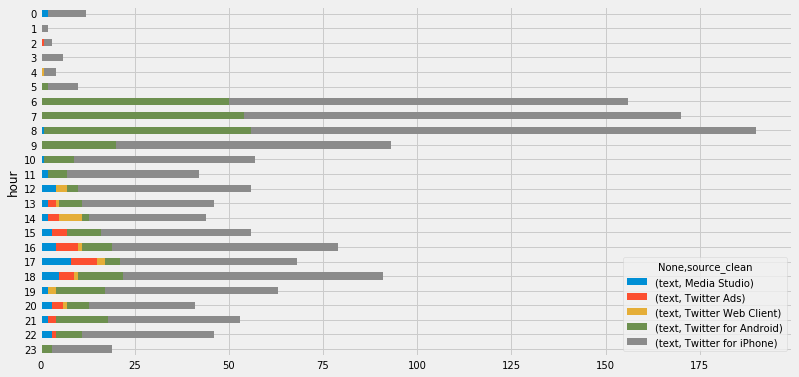

In [9]:
tweetsPerHour = tweets[['source_clean', 'hour', 'text']].pivot_table(
    index='hour', columns=['source_clean'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

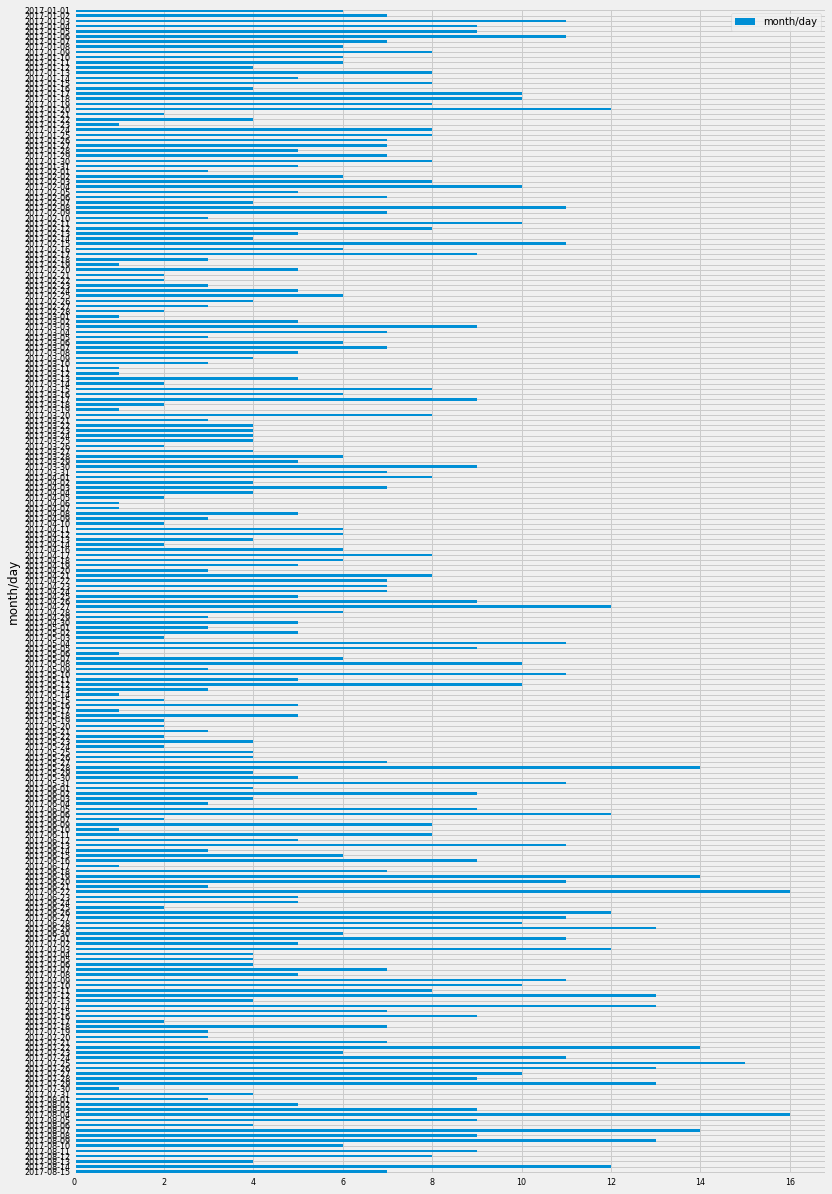

In [10]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,20), fontsize=8)

In [11]:
tweetsPerDay.describe()

,month/day
count,225.000000
mean,6.253333
std,3.490139
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,16.000000


## Tweets per day of week

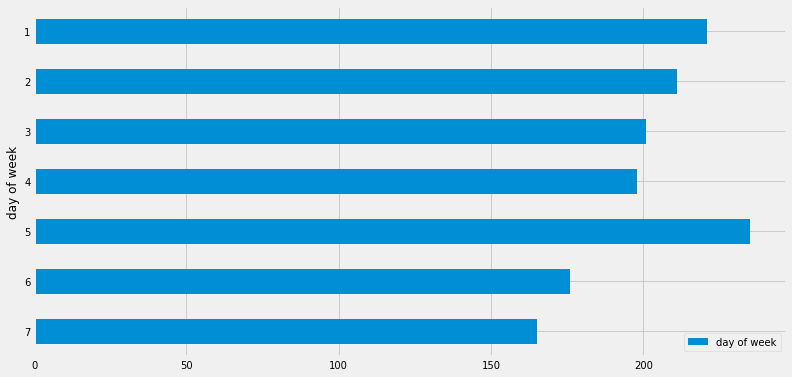

In [12]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')

## Tweets per month

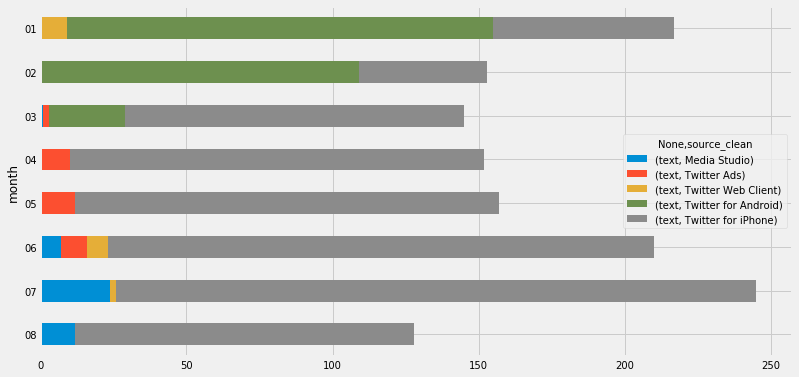

In [13]:
tweetsPerMonth = tweets[['source_clean', 'month', 'text']].pivot_table(index='month', columns=['source_clean'], aggfunc='count')
tweetsPerMonth.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per week

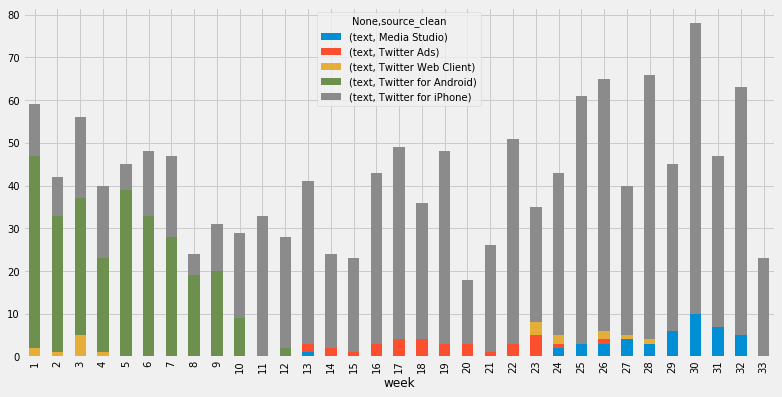

In [14]:
tweetsPerWeek = tweets[['source_clean', 'week', 'text']].pivot_table(index='week', columns=['source_clean'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

In [17]:
pd.set_option('display.width', 1000)
tweets.sort(columns='sentiment.compound')[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-04-18 10:38:59,-0.9735,Democrat Jon Ossoff would be a disaster in Con...
2017-06-13 10:35:55,-0.9544,The Fake News Media has never been so wrong or...
2017-02-07 12:11:29,-0.9370,"I don't know Putin, have no deals in Russia, a..."
2017-02-07 12:04:01,-0.9370,"I don't know Putin, have no deals in Russia, a..."
2017-01-15 22:46:33,-0.9354,.@NBCNews is bad but Saturday Night Live is th...


In [18]:
tweets.sort(columns='sentiment.compound', ascending=False)[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-01-01 06:49:49,0.9765,RT @IvankaTrump: 2016 has been one of the most...
2017-07-27 22:49:05,0.9735,It was my great HONOR to present our nation's ...
2017-01-22 12:35:09,0.9679,Had a great meeting at CIA Headquarters yester...
2017-02-02 11:25:40,0.9674,Attending Chief Ryan Owens' Dignified Transfer...
2017-02-01 03:45:26,0.9666,Hope you like my nomination of Judge Neil Gors...


In [19]:
tweets.sort(columns=['week', 'sentiment.compound'], ascending=False)[['week', 'sentiment.compound', 'text']].head(40)

,week,sentiment.compound,text
created_date,,,
2017-08-14 10:38:17,33,0.7717,Luther Strange of the Great State of Alabama h...
2017-08-15 03:06:52,33,0.7705,"Feels good to be home after seven months, but ..."
2017-08-14 22:17:11,33,0.6588,"Big day in Washington, D.C., even though White..."
2017-08-15 10:54:32,33,0.6067,"@foxandfriends According to report just out, P..."
2017-08-14 22:31:05,33,0.5994,RT @FiIibuster: @realDonaldTrump We have a Pre...
2017-08-15 12:08:01,33,0.5562,"Big day in Alabama. Vote for Luther Strange, h..."
2017-08-14 22:29:00,33,0.4840,Made additional remarks on Charlottesville and...
2017-08-13 12:17:13,33,0.4767,RT @SecretService: Our thoughts &amp; prayers ...
2017-08-15 10:55:58,33,0.4278,RT @foxandfriends: FOX NEWS EXCLUSIVE: Preside...


## By month

### Average

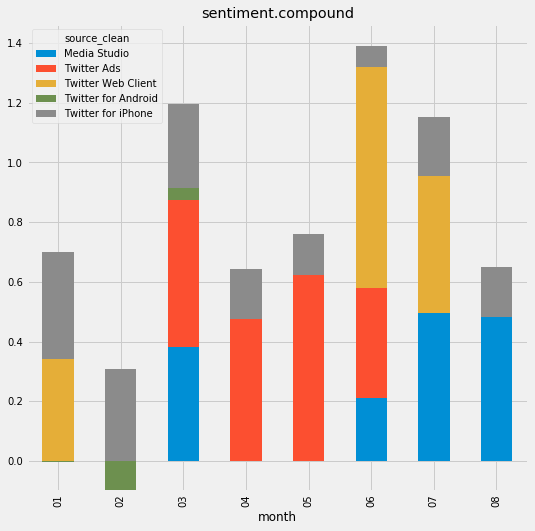

In [20]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

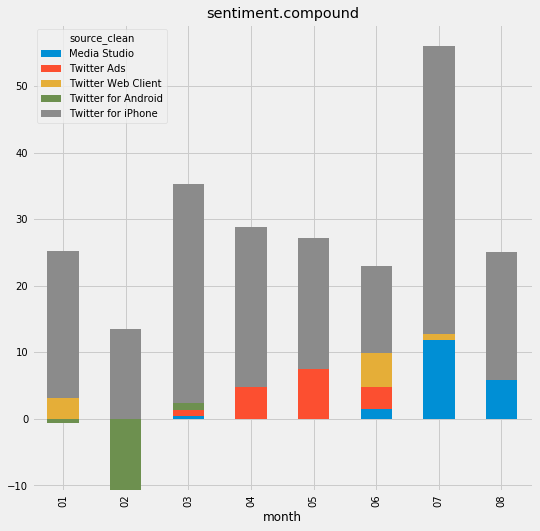

In [21]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

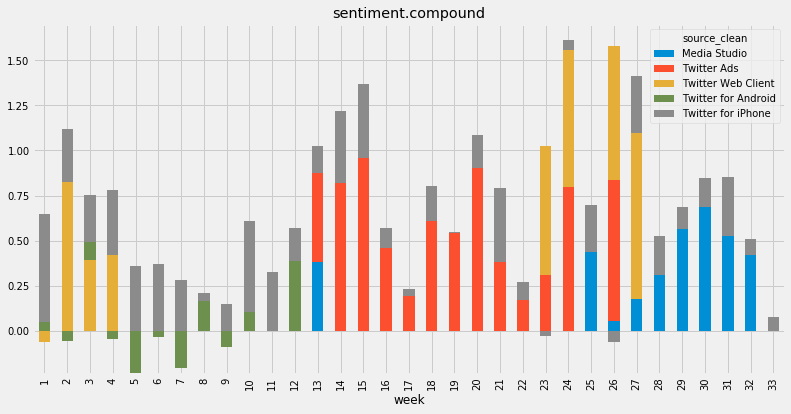

In [22]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.to_csv('output/sentiment-by-week-by-device.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

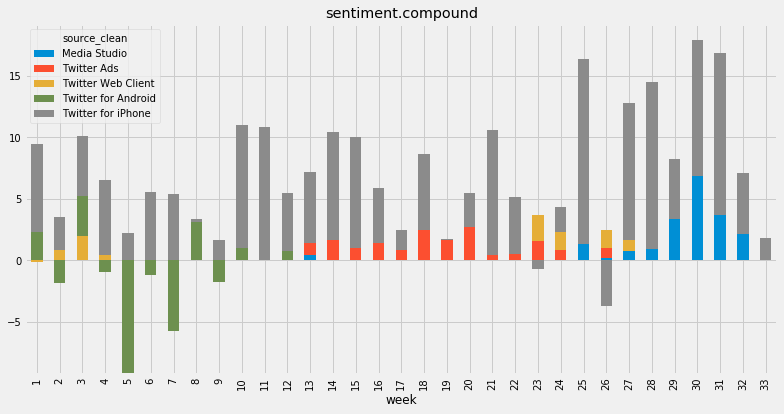

In [23]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

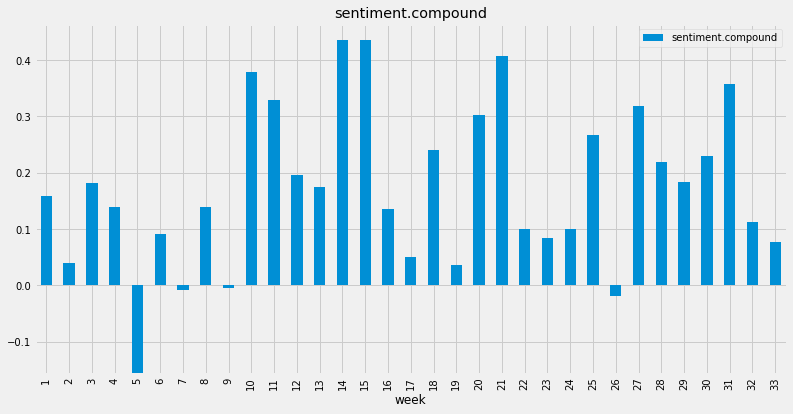

In [24]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['week', field]].groupby('week').mean()
    sentimentByMonth.to_csv('output/sentiment-by-week.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

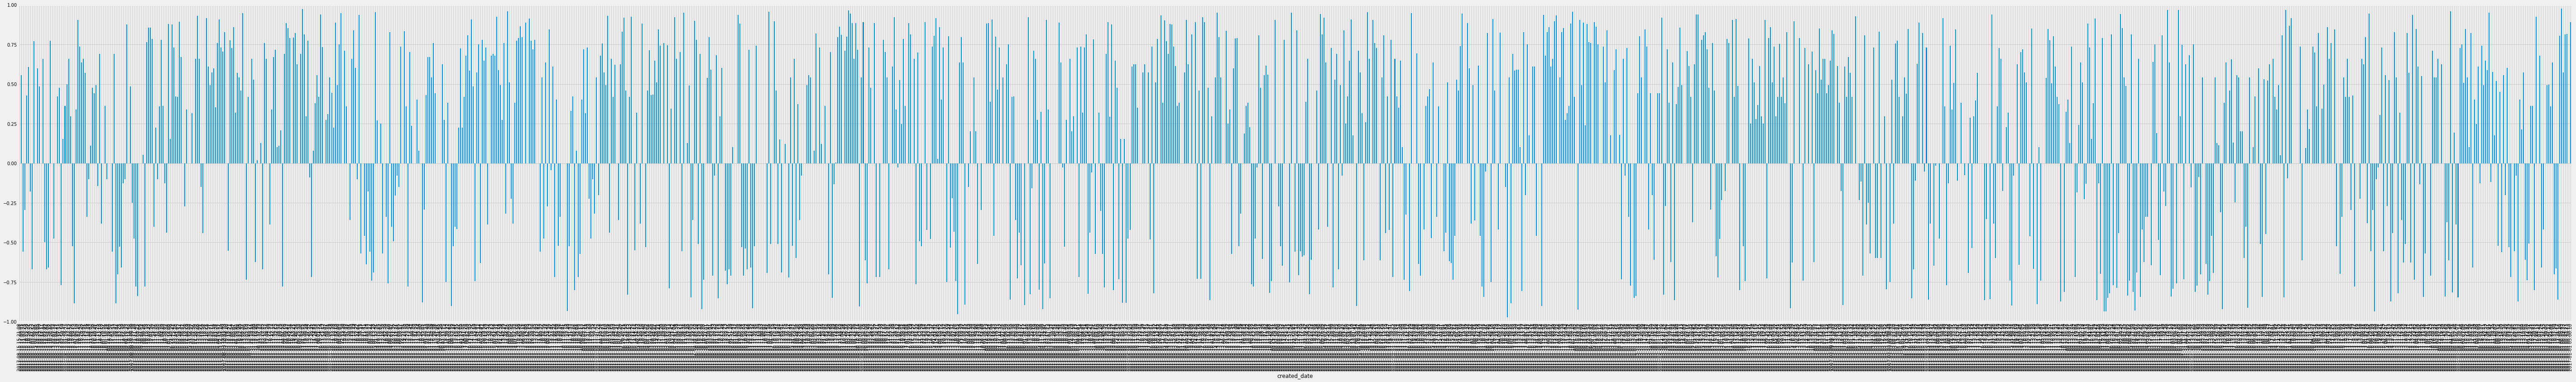

In [25]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

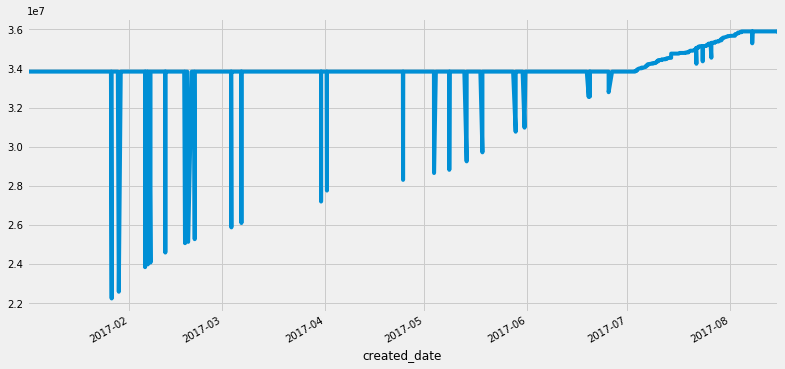

In [26]:
tweets['user.followers_count'].plot()

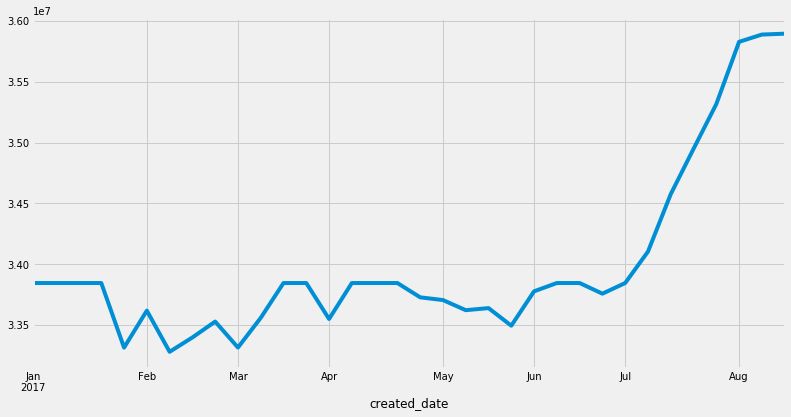

In [27]:
tweets['user.followers_count'].resample('W').plot()

# Per tweet sentiment

In [28]:
sortedSentimentPerTweet = tweets[['week', 'sentiment.compound', 'text', 'id']].sort(['week', 'sentiment.compound'], ascending=False)
# sortedSentimentPerTweet.to_csv('output/sentiment-per-tweet.csv')
sortedSentimentPerTweet

,week,sentiment.compound,text,id
created_date,,,,
2017-08-14 10:38:17,33,0.7717,Luther Strange of the Great State of Alabama h...,897044700124909569
2017-08-15 03:06:52,33,0.7705,"Feels good to be home after seven months, but ...",897293484884979712
2017-08-14 22:17:11,33,0.6588,"Big day in Washington, D.C., even though White...",897220584211439616
2017-08-15 10:54:32,33,0.6067,"@foxandfriends According to report just out, P...",897411177583702016
2017-08-14 22:31:05,33,0.5994,RT @FiIibuster: @realDonaldTrump We have a Pre...,897224082625880064
2017-08-15 12:08:01,33,0.5562,"Big day in Alabama. Vote for Luther Strange, h...",897429670278385664
2017-08-14 22:29:00,33,0.4840,Made additional remarks on Charlottesville and...,897223558073602049
2017-08-13 12:17:13,33,0.4767,RT @SecretService: Our thoughts &amp; prayers ...,896707210503483393
2017-08-15 10:55:58,33,0.4278,RT @foxandfriends: FOX NEWS EXCLUSIVE: Preside...,897411536460886016


In [29]:
df_sortedSentimentPerTweet = sortedSentimentPerTweet.reset_index()
df_sortedSentimentPerTweet['text-encoded'] = df_sortedSentimentPerTweet['text'].apply(encodeText)
df_sortedSentimentPerTweet = df_sortedSentimentPerTweet.drop('text', axis=1)
df_sortedSentimentPerTweet.to_csv('output/df_sortedSentimentPerTweet.csv')

# Text analysis

Common words.

In [30]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bmayes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
words_data.drop('Word', axis=1).to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Word,Frequency,Word Encoded
0,&amp;,240,&amp;
1,great,215,great
2,',142,'
3,!,105,!
4,-,105,-
5,fake,100,fake
6,.,91,.
7,u..,86,u..
8,big,85,big
9,news,85,news


# Specific text searches

In [32]:
from IPython.display import display, Markdown

tweetsEnc = tweets.reset_index()

def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweetsEnc[tweetsEnc['text'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweetsEnc) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    analyzedByWeek = filtered[['source_clean', 'week', 'text']].pivot_table(index='week', columns='source_clean', aggfunc='count')
    analyzedByWeek = analyzedByWeek.reindex(range(tweetsEnc['week'].min(), tweetsEnc['week'].max())).fillna(0)
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()
    analyzedByHour = filtered[['source_clean', 'hour', 'text']].pivot_table(index='hour', columns='source_clean', aggfunc='count')
    analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)
    analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))
    analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
    plt.show()
    display(Markdown('### The Tweets'))
    for i, row in filtered.iterrows():
        display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

In [33]:
tweetsEnc

,created_date,contributors,coordinates,created_at,display_text_range,extended_entities.media,favorite_count,favorited,full_text,geo,...,user.verified,human_date,month/day,month,day,day of week,hour,week,text encoded,source_clean
0,2017-08-15 15:21:08,None,None,Tue Aug 15 15:21:08 +0000 2017,"[0, 136]",NaN,33674,False,For every CEO that drops out of the Manufactur...,None,...,True,"Tuesday, Aug 15, 2017 11:21 AM",2017-08-15,08,15,2,11,33,For every CEO that drops out of the Manufactur...,Twitter for iPhone
1,2017-08-15 12:08:01,None,None,Tue Aug 15 12:08:01 +0000 2017,"[0, 62]",NaN,32111,False,"Big day in Alabama. Vote for Luther Strange, h...",None,...,True,"Tuesday, Aug 15, 2017 8:08 AM",2017-08-15,08,15,2,8,33,"Big day in Alabama. Vote for Luther Strange, h...",Twitter for iPhone
2,2017-08-15 11:03:32,None,None,Tue Aug 15 11:03:32 +0000 2017,"[0, 81]",NaN,0,False,RT @MikeHolden42: @foxandfriends @realDonaldTr...,None,...,True,"Tuesday, Aug 15, 2017 7:03 AM",2017-08-15,08,15,2,7,33,RT @MikeHolden42: @foxandfriends @realDonaldTr...,Twitter for iPhone
3,2017-08-15 11:03:23,None,None,Tue Aug 15 11:03:23 +0000 2017,"[0, 108]","[{u'source_user_id': 757731953281904640, u'sou...",0,False,RT @SLandinSoCal: @foxandfriends @realDonaldTr...,None,...,True,"Tuesday, Aug 15, 2017 7:03 AM",2017-08-15,08,15,2,7,33,RT @SLandinSoCal: @foxandfriends @realDonaldTr...,Twitter for iPhone
4,2017-08-15 10:55:58,None,None,Tue Aug 15 10:55:58 +0000 2017,"[0, 137]",NaN,0,False,RT @foxandfriends: FOX NEWS EXCLUSIVE: Preside...,None,...,True,"Tuesday, Aug 15, 2017 6:55 AM",2017-08-15,08,15,2,6,33,RT @foxandfriends: FOX NEWS EXCLUSIVE: Preside...,Twitter for iPhone
5,2017-08-15 10:54:32,None,None,Tue Aug 15 10:54:32 +0000 2017,"[15, 140]",NaN,10106,False,"@foxandfriends According to report just out, P...",None,...,True,"Tuesday, Aug 15, 2017 6:54 AM",2017-08-15,08,15,2,6,33,"@foxandfriends According to report just out, P...",Twitter for iPhone
6,2017-08-15 10:30:55,None,None,Tue Aug 15 10:30:55 +0000 2017,"[0, 139]",NaN,27838,False,"Senator Luther Strange, who is doing a great j...",None,...,True,"Tuesday, Aug 15, 2017 6:30 AM",2017-08-15,08,15,2,6,33,"Senator Luther Strange, who is doing a great j...",Twitter for iPhone
7,2017-08-15 03:11:23,None,None,Tue Aug 15 03:11:23 +0000 2017,"[0, 140]",NaN,0,False,RT @JackPosobiec: Meanwhile: 39 shootings in C...,None,...,True,"Monday, Aug 14, 2017 11:11 PM",2017-08-14,08,14,1,23,33,RT @JackPosobiec: Meanwhile: 39 shootings in C...,Twitter for iPhone
8,2017-08-15 03:06:52,None,None,Tue Aug 15 03:06:52 +0000 2017,"[0, 139]",NaN,87294,False,"Feels good to be home after seven months, but ...",None,...,True,"Monday, Aug 14, 2017 11:06 PM",2017-08-14,08,14,1,23,33,"Feels good to be home after seven months, but ...",Twitter for iPhone
9,2017-08-15 02:38:05,None,None,Tue Aug 15 02:38:05 +0000 2017,"[0, 106]",NaN,0,False,RT @foxandfriends: Sec. Mattis: If North Korea...,None,...,True,"Monday, Aug 14, 2017 10:38 PM",2017-08-14,08,14,1,22,33,RT @foxandfriends: Sec. Mattis: If North Korea...,Twitter for iPhone


## Search: _great_

Number of Tweets: 231

Percent of all Tweets: 16.42%

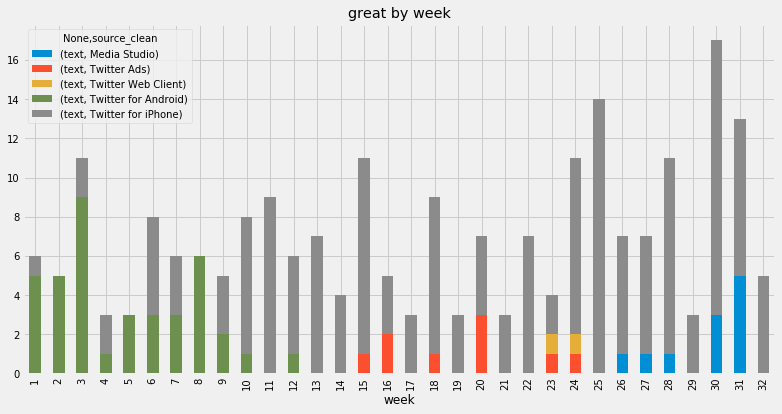

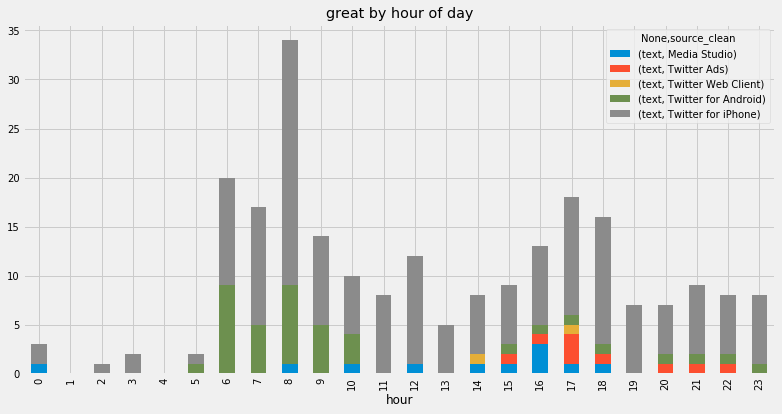

### The Tweets

[Tuesday, Aug 15, 2017 8:08 AM](https://twitter.com/realDonaldTrump/status/897429670278385664): Big day in Alabama. Vote for Luther Strange, he will be great!

[Tuesday, Aug 15, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/897405235924275200): Senator Luther Strange, who is doing a great job for the people of Alabama, will be on @foxandfriends at 7:15. Tough on crime, borders etc.

[Monday, Aug 14, 2017 6:17 PM](https://twitter.com/realDonaldTrump/status/897220584211439616): Big day in Washington, D.C., even though White House &amp; Oval Office are being renovated. Great trade deals coming for American workers!

[Monday, Aug 14, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/897044700124909569): Luther Strange of the Great State of Alabama has my endorsement. He is strong on Border &amp; Wall, the military, tax cuts &amp; law enforcement.

[Thursday, Aug 10, 2017 12:40 PM](https://twitter.com/realDonaldTrump/status/895686351529672704): Mitch, get back to work and put Repeal &amp; Replace, Tax Reform &amp; Cuts and a great Infrastructure Bill on my desk for signing. You can do it!

[Tuesday, Aug 8, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/895091395379245056): Senator Luther Strange has done a great job representing the people of the Great State of Alabama. He has my complete and total endorsement!

UnicodeEncodeError: 'ascii' codec can't encode characters in position 39-40: ordinal not in range(128)

In [34]:
searches = ['great', 'fake', 'mexic', 'fox', 'terror', 'ivanka', 'ms 13', 'russia', 'failing', 'election']
for search in searches:
    analyzeText(search)